# Prepare text files for each entry
- reference
- Pero OCR
- Tesseract OCR

In [1]:
import os.path

In [2]:
DATASET_PATH = os.path.abspath("../../dataset/supervised")
DATASET_PATH

'/home/joseph/git_github/soduco/paper-ner-bench-das22/dataset/supervised'

In [3]:
ref_path = os.path.join(DATASET_PATH, "10-ref-ocr-ner-json", "all.json")
pero_path = os.path.join(DATASET_PATH, "21-ocr-pero-final", "all.json")
tess_path = os.path.join(DATASET_PATH, "22-ocr-tess-final", "all.json")
krak_path = os.path.join(DATASET_PATH, "23-ocr-krak-final", "all.json")

## Generate report OCR report

In [4]:
import OCRMetrics
import pandas as pd
import json

with open(ref_path) as f:
    reference = json.load(f)
with open(pero_path) as f:
    pero = json.load(f)
with open(tess_path) as f:
    tess = json.load(f)
with open(krak_path) as f:
    krak = json.load(f)

uid = lambda x: (x["book"], x["page"], x["id"]) 
ref = { uid(x) : x["text_ocr"] for x in reference }
boxes = { uid(x) : tuple(int(r) for r in x["box"]) for x in reference }
pero = { uid(x) : x["text_ocr"] for x in pero }
tess = { uid(x) : x["text_ocr"] for x in tess }
krak = { uid(x) : x["text_ocr"] for x in krak }
all_keys = ref.keys() & pero.keys() & tess.keys() & krak.keys()
valid_keys = set(uid(x) for x in reference if x["valid_box"])

pero_scores = { k : OCRMetrics.align(ref[k], pero[k]) for k in all_keys }
tess_scores = { k : OCRMetrics.align(ref[k], tess[k]) for k in all_keys }
krak_scores = { k : OCRMetrics.align(ref[k], krak[k]) for k in all_keys }

def make_df(scores, index):
    stats = { k : r.stats for k,r in scores.items() }
    data = [ (k[0], k[1], k[2], s.errors, s.reference_length, s.length, index[k]) for k, s in stats.items() ]
    df = pd.DataFrame.from_records(data, columns=["Book", "Page", "Id", "Errors", "RefLength", "Length", "TextPred"] )
    df = df.set_index(["Book", "Page", "Id"])
    return df

pero_df = make_df(pero_scores, pero)
tess_df = make_df(tess_scores, tess)
krak_df = make_df(krak_scores, krak)
#all_df = pd.merge(pero_df, tess_df, suffixes=["_pero", "_tess"], how="inner", on=["Book", "Page", "Id"])



## Sanity checks

In [5]:
# al = OCRMetrics.align("aaaabb", "aaacbbb")
# al.aligned_ref, al.aligned_x, al.reference, al.stats, al.x

Note that dict keys are set-like objects.

In [6]:
# pero.keys?

In [7]:
assert(all_keys == valid_keys)

In [8]:
# Pero and Tess must have the same entries
assert(len(pero.keys() ^ tess.keys()) == 0)
assert(len(pero.keys() ^ krak.keys()) == 0)
assert(len(tess.keys() ^ krak.keys()) == 0)

In [9]:
# Pero and Tess must have only valid boxes
assert(pero.keys() == valid_keys)
assert(tess.keys() == valid_keys)
assert(krak.keys() == valid_keys)

In [10]:
# Pero and Tess must be included in Ref
assert(pero.keys() <= ref.keys())
assert(tess.keys() <= ref.keys())
assert(krak.keys() <= ref.keys())

In [11]:
# Check for duplicate ids
# -> Should be done before

## Normalization variants

In [12]:
from text_utils import ocr_simplifications_for_evaluation

In [34]:
%%time
variants = {
    "strict": lambda s: ocr_simplifications_for_evaluation(s,
                    normalize_spaces=False,
                    normalize_dashes=False,
                    normalize_brackets=False,
                    normalize_quotes=False,
                    normalize_punctuation=False,
                    remove_accents=False,
                    deduplicate_spaces=False,
                    apply_french_spacing_rules=False,
                    casefold=False),
    "norm_accents": lambda s: ocr_simplifications_for_evaluation(s,
                    remove_accents=True),
    "norm_accents_case": lambda s: ocr_simplifications_for_evaluation(s,
                    remove_accents=True,
                    casefold=True),
    "norm_punct": lambda s: ocr_simplifications_for_evaluation(s,
                    normalize_punctuation=True),
    "norm_case": lambda s: ocr_simplifications_for_evaluation(s,
                            casefold=True),
    "norm_spaces": lambda s: ocr_simplifications_for_evaluation(s,
                    normalize_spaces=True,
                    deduplicate_spaces=True,
                    apply_french_spacing_rules=False),
    "norm_spaces_frrules": lambda s: ocr_simplifications_for_evaluation(s,
                    normalize_spaces=True,
                    deduplicate_spaces=True,
                    apply_french_spacing_rules=True),
    "norm_all": lambda s: ocr_simplifications_for_evaluation(s,
                    normalize_spaces=True,
                    normalize_dashes=True,
                    normalize_brackets=True,
                    normalize_quotes=True,
                    normalize_punctuation=True,
                    remove_accents=True,
                    deduplicate_spaces=True,
                    apply_french_spacing_rules=True,
                    casefold=True),
}

ocr_preds = {
    "pero": pero,
    "tess": tess,
    "krak": krak,
}


summary = []
for name, normalizer in variants.items():
    # print("="*20)
    # print(f"Variant: {name}")
    
    for ocr_name, ocr_pred in ocr_preds.items():
        stats = { k : OCRMetrics.align(normalizer(ref[k]), normalizer(ocr_pred[k])).stats for k in all_keys }
        data = [ (k[0], k[1], k[2], s.errors, s.reference_length, s.length, ocr_pred[k]) for k, s in stats.items() ]
        ocr_df = pd.DataFrame.from_records(data, columns=["Book", "Page", "Id", "Errors", "RefLength", "Length", "TextPred"] )
        ocr_df = ocr_df.set_index(["Book", "Page", "Id"])
        ocr_cer = ocr_df["Errors"].sum() / ocr_df["RefLength"].sum()
        summary.append((name, ocr_name, 100 * ocr_cer, 100 * (1 - ocr_cer)))
        # print(f"Variant: {name:18s} OCR: {ocr_name:5s} CER: {100 * ocr_cer:6.2f}% Accuracy: {100 * (1 - ocr_cer):6.2f}%")
summary = pd.DataFrame.from_records(summary, columns=("Variant", "OCR", "CER", "Accuracy"))

with pd.option_context('display.max_rows', 30,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 5,
                       'display.colheader_justify', 'center'):
    display(summary)

,Variant,OCR,CER,Accuracy
0,strict,pero,3.78,96.22
1,strict,tess,6.56,93.44
2,strict,krak,15.72,84.28
3,norm_accents,pero,3.54,96.46
4,norm_accents,tess,6.27,93.73
5,norm_accents,krak,14.76,85.24
6,norm_accents_case,pero,3.49,96.51
7,norm_accents_case,tess,6.09,93.91
8,norm_accents_case,krak,14.64,85.36
9,norm_punct,pero,3.62,96.38


CPU times: user 36.8 s, sys: 288 ms, total: 37.1 s
Wall time: 37.1 s


## Comparison between OCR systems

In [14]:
CER_pero = pero_df["Errors"] / pero_df["RefLength"]
CERnorm_pero = pero_df["Errors"] / pero_df["Length"]
CER_tess = tess_df["Errors"] / tess_df["RefLength"]
CERnorm_tess = tess_df["Errors"] / tess_df["Length"]
CER_krak = krak_df["Errors"] / krak_df["RefLength"]
CERnorm_krak = krak_df["Errors"] / krak_df["Length"]


uniq_df = pd.DataFrame( data = [ (k[0], k[1], k[2], ref[k], boxes[k]) for k in all_keys ], columns=["Book", "Page", "Id", "TextRef", "Boxes"])
uniq_df = uniq_df.set_index(["Book", "Page", "Id"])

errors = pd.DataFrame( { 
    "Pero": CER_pero, "Tess" : CER_tess , "Krak" : CER_krak ,
    "PeroPred" : pero_df["TextPred"], "TessPred" : tess_df["TextPred"], "KrakPred" : krak_df["TextPred"]})
errors = pd.concat([errors, uniq_df], axis=1, join='inner')  

(0.01, 1.0)

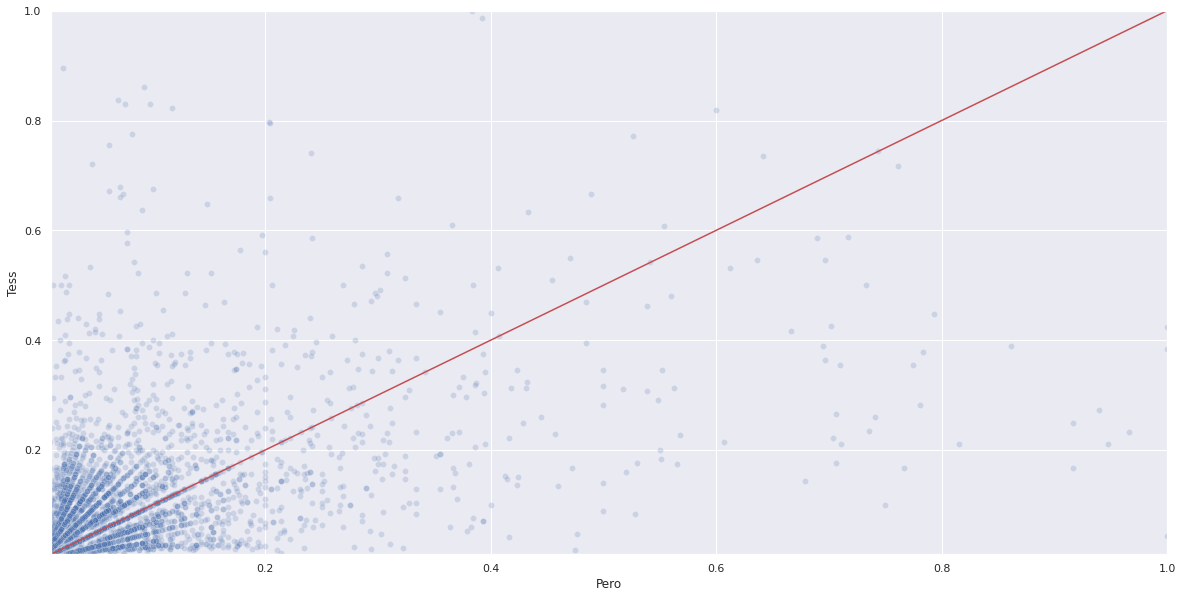

In [15]:
import seaborn as sns
import matplotlib.lines as lines
import matplotlib.pyplot as plt
sns.set_theme()

fig, ax = plt.subplots(figsize=(20,10))
fig = sns.scatterplot(data = errors, x = "Pero", y = "Tess", ax=ax, alpha=0.2)
fig.add_artist(lines.Line2D([0, 1], [0, 1], color='r'))
#fig.set_xscale("log")
#fig.set_yscale("log")
fig.set_xlim(0.01, 1)
fig.set_ylim(0.01, 1)

#errors

(0.01, 1.0)

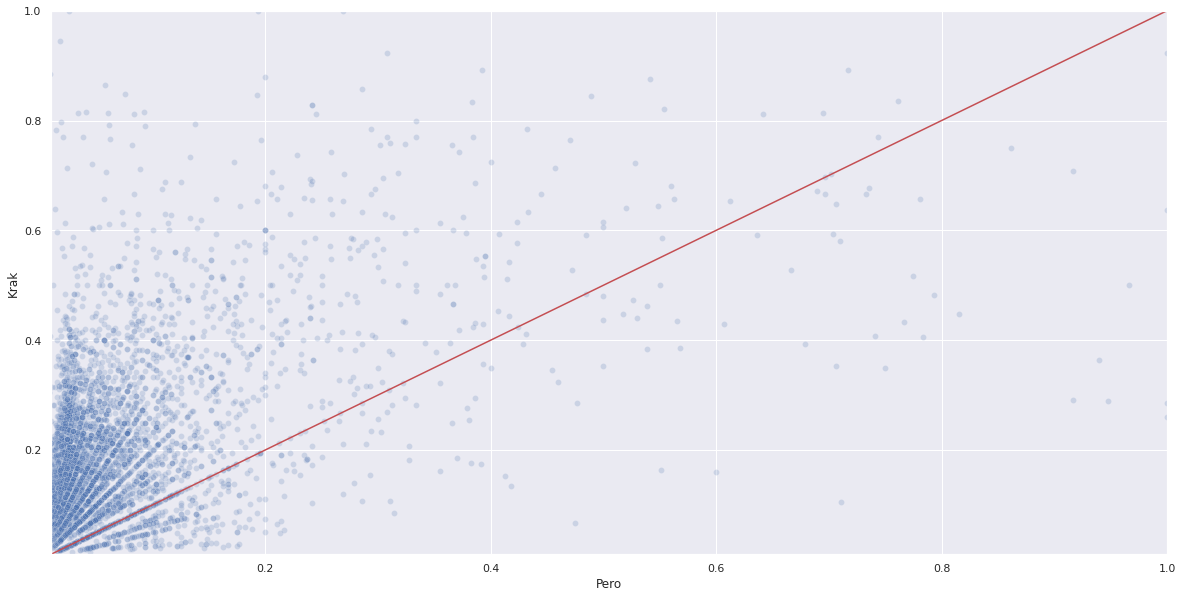

In [35]:
fig, ax = plt.subplots(figsize=(20,10))
fig = sns.scatterplot(data = errors, x = "Pero", y = "Krak", ax=ax, alpha=0.2)
fig.add_artist(lines.Line2D([0, 1], [0, 1], color='r'))
#fig.set_xscale("log")
#fig.set_yscale("log")
fig.set_xlim(0.01, 1)
fig.set_ylim(0.01, 1)

(0.01, 1.0)

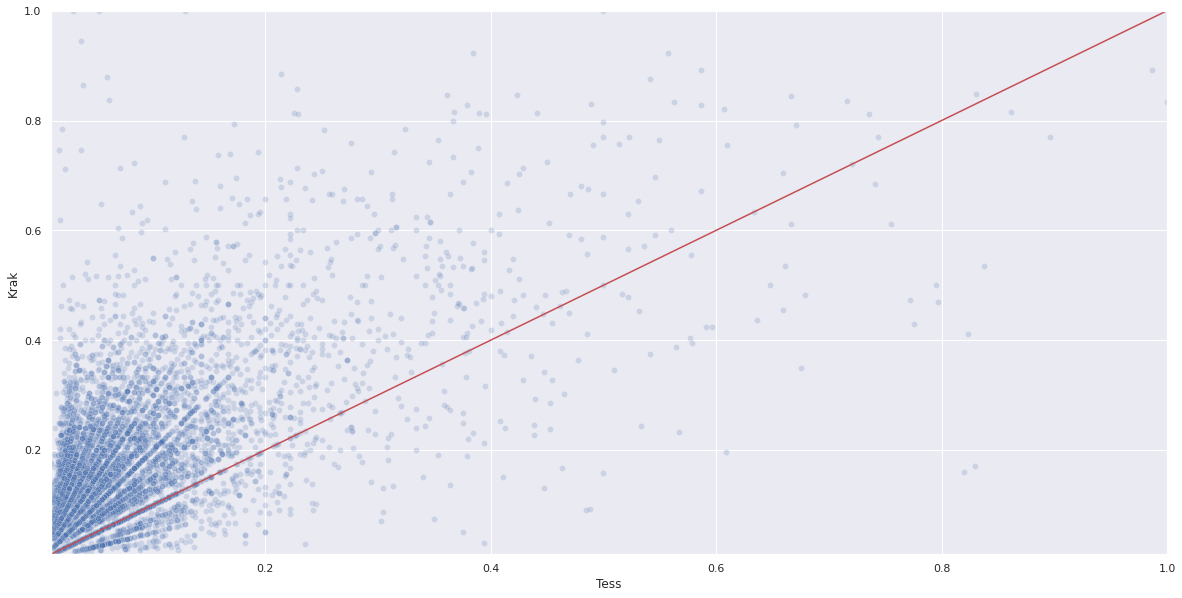

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
fig = sns.scatterplot(data = errors, x = "Tess", y = "Krak", ax=ax, alpha=0.2)
fig.add_artist(lines.Line2D([0, 1], [0, 1], color='r'))
#fig.set_xscale("log")
#fig.set_yscale("log")
fig.set_xlim(0.01, 1)
fig.set_ylim(0.01, 1)

<AxesSubplot:>

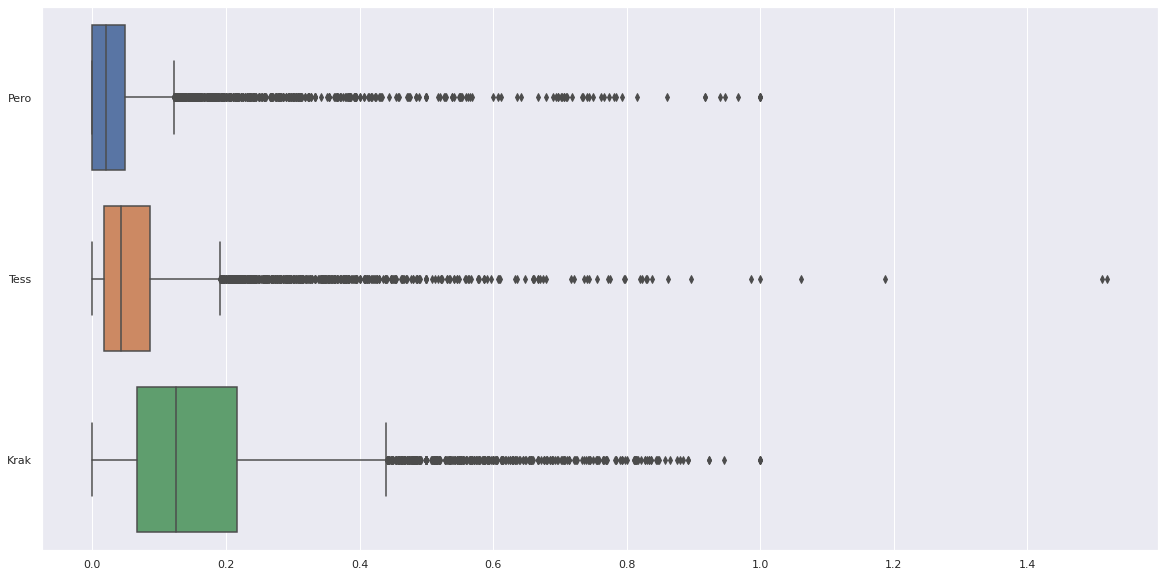

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=errors, orient='h', ax=ax)

In [17]:
byerr = errors.sort_values(by=["Pero"])
byerr[(byerr["Pero"] >= 0.9) | (byerr["Tess"] >= 0.9)]
is_valid = lambda b: b[2] > 50
valid = errors["Boxes"].apply(is_valid)
pd.options.display.float_format = '{:,.2f}'.format
errors[~valid]

,,,Pero,Tess,Krak,PeroPred,TessPred,KrakPred,TextRef,Boxes
Book,Page,Id,,,,,,,,


In [18]:
# errors.loc["Bottin1_1827",117,:].sort_index().loc[520:]

In [19]:
pero_cer = pero_df["Errors"].sum() / pero_df["RefLength"].sum()
tess_cer = tess_df["Errors"].sum() / tess_df["RefLength"].sum()
krak_cer = krak_df["Errors"].sum() / krak_df["RefLength"].sum()

print("Pero CER: {:.2f}%".format(100 * pero_cer))
print("Tess CER: {:.2f}%".format(100 * tess_cer))
print("Krak CER: {:.2f}%".format(100 * krak_cer))
print("Pero Accuracy: {:.2f}%".format(100 * (1 - pero_cer)))
print("Tess Accuracy: {:.2f}%".format(100 * (1 - tess_cer)))
print("Krak Accuracy: {:.2f}%".format(100 * (1 - krak_cer)))

Pero CER: 3.78%
Tess CER: 6.56%
Krak CER: 15.72%
Pero Accuracy: 96.22%
Tess Accuracy: 93.44%
Krak Accuracy: 84.28%


## With ISRI

In [20]:
import isri_tools

In [21]:
def print_report(report):
    for attr in ("characters", "errors", "false_marks", "reject_characters", "suspect_markers"):
        val = getattr(report, attr)
        print(f"{attr:20s}: {val:10d}")
    accuracy = (report.characters - report.errors) / report.characters
    print(f"{'accuracy':20s}: {accuracy*100:10.2f}%")

In [22]:
type(ref), type(pero)

(dict, dict)

In [23]:
pero_report = isri_tools.compute_accurary_summary(
    [ref[k] for k in valid_keys], 
    [pero[k] for k in valid_keys]
    )
pero_report

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  424764   Characters
   16063   Errors
   96.22%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   96.22%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    6225     7615     2223    16063   Unmarked
    6225     7615     2223    16063   Total

   Count   Missed   %Right
   54387     3185    94.14   ASCII Spacing Characters
   57915     3837    93.37   ASCII Special Symbols
   18144     1470    91.90   ASCII Digits
   31971      582    98.18   ASCII Uppercase Letters
  255201     3336    98.69   ASCII Lowercase Letters
      66       41    37.88   Latin1 Special Symbols
      51       44    13.73   Latin1 Uppercase Letters
    6233      912    85.37   Latin1 Lowercase Letters
      25        7    72.00   Latin Extended-A
     383       42    89.03   General Punctuation
 

In [24]:
tess_report = isri_tools.compute_accurary_summary(
    [ref[k] for k in valid_keys], 
    [tess[k] for k in valid_keys]
    )
tess_report

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  424764   Characters
   27862   Errors
   93.44%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   93.44%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    4506    16416     6940    27862   Unmarked
    4506    16416     6940    27862   Total

   Count   Missed   %Right
   54387     1643    96.98   ASCII Spacing Characters
   57915     4750    91.80   ASCII Special Symbols
   18144     2450    86.50   ASCII Digits
   31971     2414    92.45   ASCII Uppercase Letters
  255201     8308    96.74   ASCII Lowercase Letters
      66       26    60.61   Latin1 Special Symbols
      51       26    49.02   Latin1 Uppercase Letters
    6233      873    85.99   Latin1 Lowercase Letters
      25       10    60.00   Latin Extended-A
     383       34    91.12   General Punctuation
 

In [25]:
krak_report = isri_tools.compute_accurary_summary(
    [ref[k] for k in valid_keys], 
    [krak[k] for k in valid_keys]
    )
krak_report

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  424764   Characters
   66786   Errors
   84.28%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   84.28%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
   25554    34012     7220    66786   Unmarked
   25554    34012     7220    66786   Total

   Count   Missed   %Right
   54387     3400    93.75   ASCII Spacing Characters
   57915     5275    90.89   ASCII Special Symbols
   18144     6806    62.49   ASCII Digits
   31971     7234    77.37   ASCII Uppercase Letters
  255201    29705    88.36   ASCII Lowercase Letters
      66       66     0.00   Latin1 Special Symbols
      51       51     0.00   Latin1 Uppercase Letters
    6233     6233     0.00   Latin1 Lowercase Letters
      25       25     0.00   Latin Extended-A
     383      383     0.00   General Punctuation
 

## With more normalization

In [26]:
simplify = lambda s: ocr_simplifications_for_evaluation(s,
                    normalize_spaces=True,
                    normalize_dashes=True,
                    normalize_brackets=True,
                    normalize_quotes=True,
                    normalize_punctuation=True,
                    remove_accents=True,
                    deduplicate_spaces=True,
                    apply_french_spacing_rules=True,
                    casefold=True)
pero_simplified_report = isri_tools.compute_accurary_summary(
    [simplify(ref[k]) for k in valid_keys], 
    [simplify(pero[k]) for k in valid_keys]
    )
# Maybe too permissive, but shows the cost of missing text parts
pero_simplified_report

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  423101   Characters
   11592   Errors
   97.26%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   97.26%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    5698     4165     1729    11592   Unmarked
    5698     4165     1729    11592   Total

   Count   Missed   %Right
   52708     1195    97.73   ASCII Spacing Characters
   58298     3127    94.64   ASCII Special Symbols
   18144     1478    91.85   ASCII Digits
  293497     3638    98.76   ASCII Lowercase Letters
      66       41    37.88   Latin1 Special Symbols
      77       77     0.00   Enclosed Alphanumerics
      13        9    30.77   Miscellaneous Symbols
     298      298     0.00   Private Use Area
  423101     9863    97.67   Total

  Errors   Marked   Correct-Generated
     918        0   {.}-{}
     39

In [27]:
simplify = lambda s: ocr_simplifications_for_evaluation(s,
                    normalize_spaces=True,
                    normalize_dashes=True,
                    normalize_brackets=False,
                    normalize_quotes=False,
                    normalize_punctuation=False,
                    remove_accents=False,
                    deduplicate_spaces=True,
                    apply_french_spacing_rules=True,
                    casefold=False)
pero_simplified_report = isri_tools.compute_accurary_summary(
    [simplify(ref[k]) for k in valid_keys], 
    [simplify(pero[k]) for k in valid_keys]
    )
# Less permissive, shows actual frequent character substitutions
pero_simplified_report

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
  422228   Characters
   13422   Errors
   96.82%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   96.82%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    5572     6119     1731    13422   Unmarked
    5572     6119     1731    13422   Total

   Count   Missed   %Right
   51835     1100    97.88   ASCII Spacing Characters
   58298     3819    93.45   ASCII Special Symbols
   18144     1476    91.87   ASCII Digits
   31971      580    98.19   ASCII Uppercase Letters
  255233     3334    98.69   ASCII Lowercase Letters
      66       41    37.88   Latin1 Special Symbols
      51       44    13.73   Latin1 Uppercase Letters
    6233      912    85.37   Latin1 Lowercase Letters
       9        1    88.89   Latin Extended-A
      77       77     0.00   Enclosed Alphanumeric

## Charset study

In [28]:

from text_utils import charset_stats
ref_charset = charset_stats(ref[k] for k in valid_keys)
ref_charset

,repr,ord,name,category,count
0,' ',32,SPACE,Zs,50766
1,'e',101,LATIN SMALL LETTER E,Ll,39418
2,'r',114,LATIN SMALL LETTER R,Ll,25019
3,"','",44,COMMA,Po,24839
4,'a',97,LATIN SMALL LETTER A,Ll,21196
...,...,...,...,...,...
107,'Ⓟ',9413,CIRCLED LATIN CAPITAL LETTER P,So,2
108,'Î',206,LATIN CAPITAL LETTER I WITH CIRCUMFLEX,Lu,1
109,'ñ',241,LATIN SMALL LETTER N WITH TILDE,Ll,1
110,'{',123,LEFT CURLY BRACKET,Ps,1


In [29]:
pero_charset = charset_stats(pero[k] for k in valid_keys)
pero_charset

,repr,ord,name,category,count
0,' ',32,SPACE,Zs,48368
1,'e',101,LATIN SMALL LETTER E,Ll,39632
2,'r',114,LATIN SMALL LETTER R,Ll,24894
3,"','",44,COMMA,Po,23818
4,'a',97,LATIN SMALL LETTER A,Ll,21154
...,...,...,...,...,...
125,'и',1080,CYRILLIC SMALL LETTER I,Ll,1
126,'н',1085,CYRILLIC SMALL LETTER EN,Ll,1
127,'т',1090,CYRILLIC SMALL LETTER TE,Ll,1
128,'х',1093,CYRILLIC SMALL LETTER HA,Ll,1


In [30]:
tess_charset = charset_stats(tess[k] for k in valid_keys)
tess_charset

,repr,ord,name,category,count
0,' ',32,SPACE,Zs,52252
1,'e',101,LATIN SMALL LETTER E,Ll,39431
2,"','",44,COMMA,Po,25616
3,'r',114,LATIN SMALL LETTER R,Ll,25245
4,'a',97,LATIN SMALL LETTER A,Ll,21137
...,...,...,...,...,...
125,'Ê',202,LATIN CAPITAL LETTER E WITH CIRCUMFLEX,Lu,2
126,'Î',206,LATIN CAPITAL LETTER I WITH CIRCUMFLEX,Lu,2
127,'Ü',220,LATIN CAPITAL LETTER U WITH DIAERESIS,Lu,2
128,'Ë',203,LATIN CAPITAL LETTER E WITH DIAERESIS,Lu,1


In [31]:
krak_charset = charset_stats(krak[k] for k in valid_keys)
krak_charset

,repr,ord,name,category,count
0,' ',32,SPACE,Zs,49102
1,'e',101,LATIN SMALL LETTER E,Ll,41588
2,"','",44,COMMA,Po,24514
3,'r',114,LATIN SMALL LETTER R,Ll,24053
4,'i',105,LATIN SMALL LETTER I,Ll,21958
...,...,...,...,...,...
77,'&',38,AMPERSAND,Po,8
78,'+',43,PLUS SIGN,Sm,7
79,'Z',90,LATIN CAPITAL LETTER Z,Lu,7
80,'X',88,LATIN CAPITAL LETTER X,Lu,5


In [32]:
def charset_distribution(charset, title):
    plt.figure(figsize=(20, 10))
    xs = list(range(len(charset)))
    plt.plot(xs, charset["count"]/charset["count"].sum())
    plt.xticks(xs, [s.strip("\"'") for s in charset["repr"]])
    plt.title(title)
    plt.show()

/home/joseph/.virtualenvs/pybind-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9398 (\N{CIRCLED LATIN CAPITAL LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joseph/.virtualenvs/pybind-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9412 (\N{CIRCLED LATIN CAPITAL LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joseph/.virtualenvs/pybind-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9399 (\N{CIRCLED LATIN CAPITAL LETTER B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/joseph/.virtualenvs/pybind-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9413 (\N{CIRCLED LATIN CAPITAL LETTER P}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


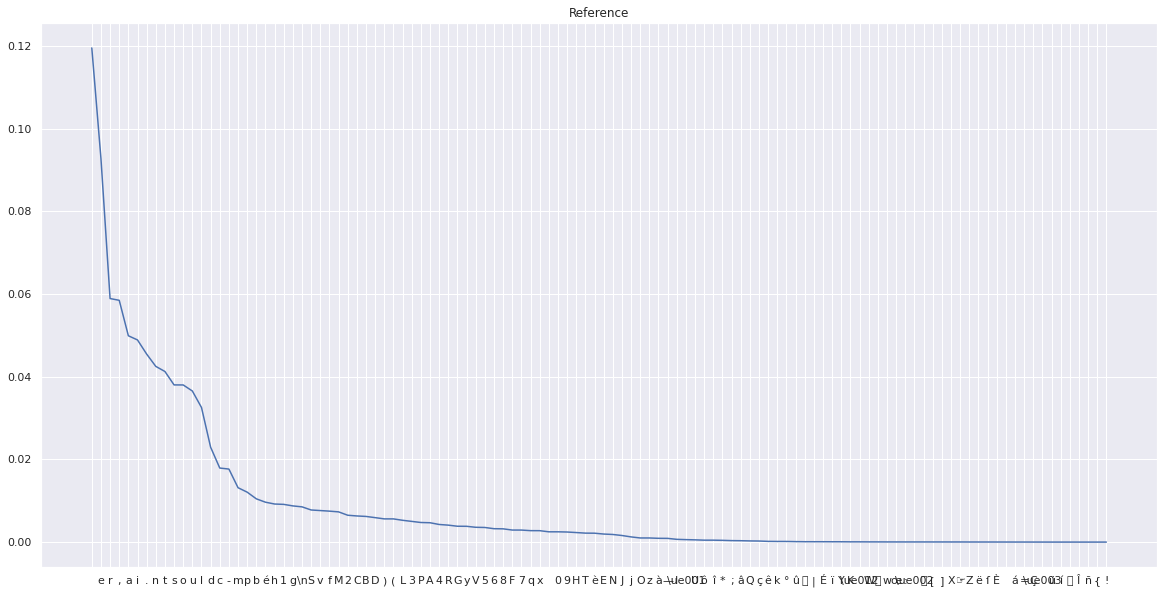

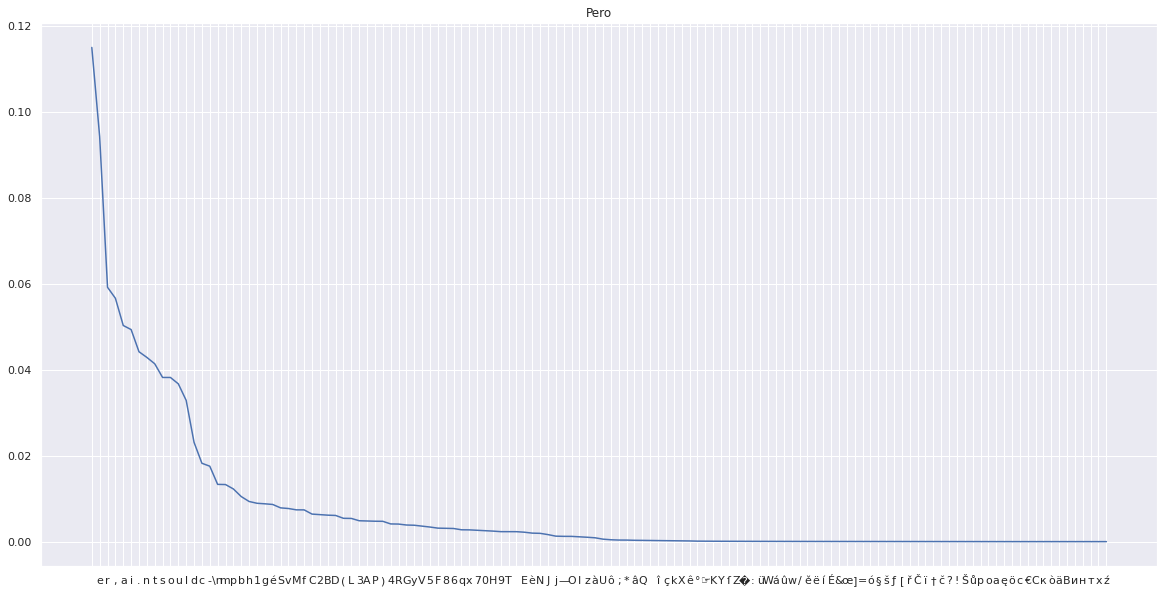

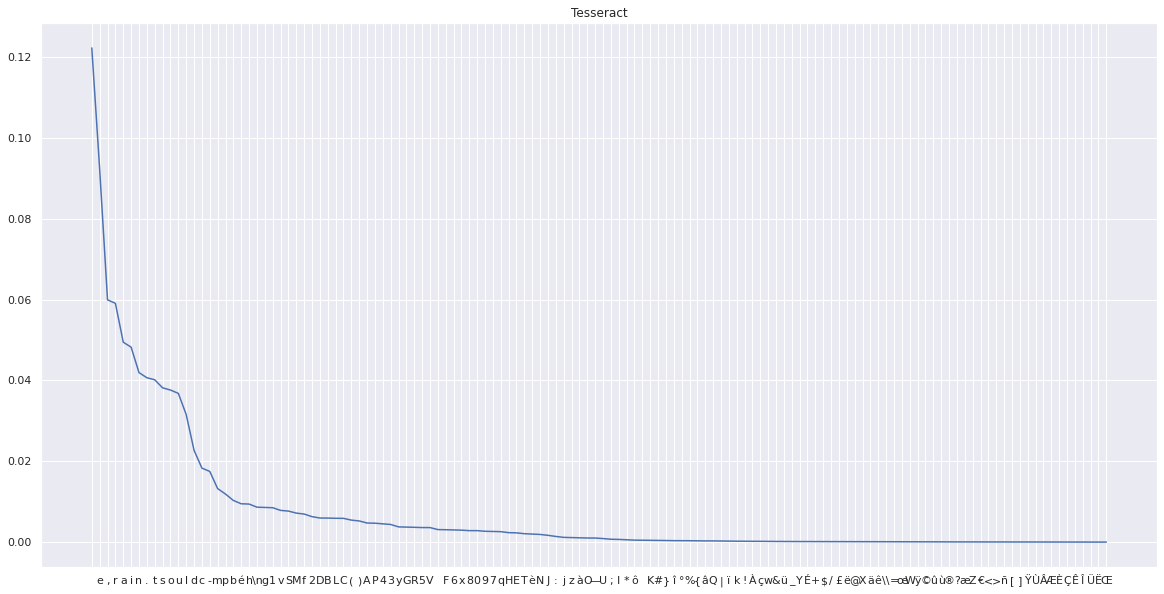

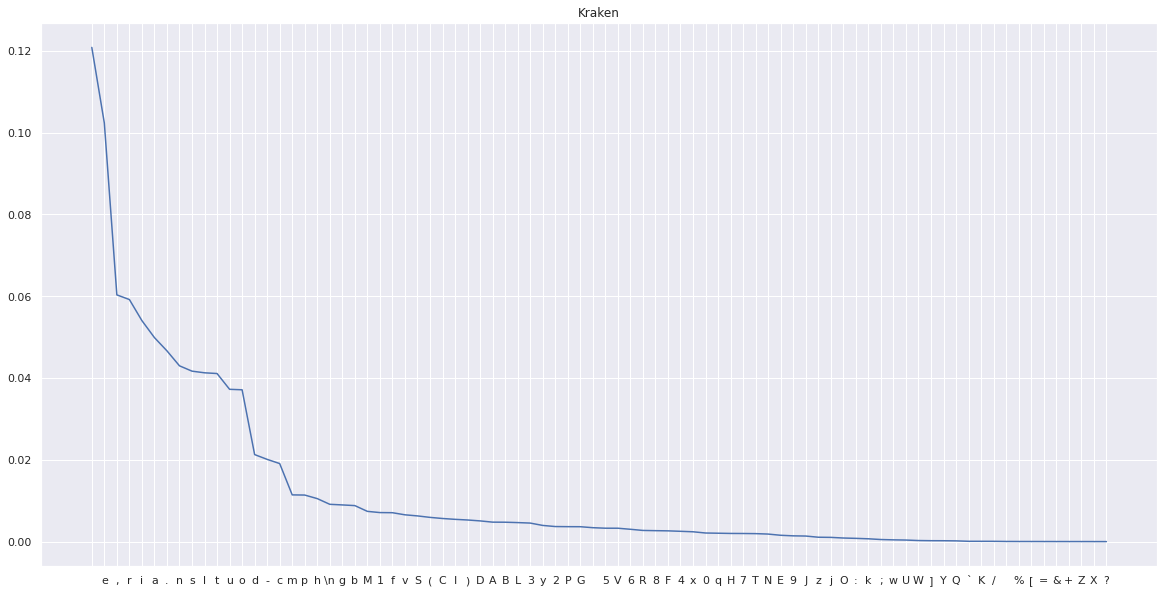

In [33]:
charset_distribution(ref_charset, "Reference")
charset_distribution(pero_charset, "Pero")
charset_distribution(tess_charset, "Tesseract")
charset_distribution(krak_charset, "Kraken")